# Exploring Venues in Shimla, India

## Table of Contents

<ul>
    <li>Introduction</li>
    <li>Data Collection</li>
    <li>Data Cleaning</li>
    <li>Methodology</li>
    <li>Analysis</li>
    <li>Results and Discussion</li>
    <li>Conclusion</li>
</ul>

## Introduction

Whenever a person is visiting or planning to visit a new city, he/she always wants to know what the city has in store for them, And a city’s restaurants and cafe’s are a major part of the experience when someone visits a city, Most of the people who visit these restaurants, might want to know about the food and ratings of the given place. This information can help people decide about the places the want to eat and help them get reservations if needed.
Shimla city is spread over an area of 35.34 km2 and has various number of places spread over the city, as in most these places vehicles are not allowed (near the mall road) so it would be very helpful for the people to efficiently find their kind of place to eat. By using the foursquare API we’ll be able to provide people with sufficient knowledge about the place they are visiting and what to expect from the place.


### Data Collection form APIs

To begin with, we will take a look at Shimla on the Map using the folium library.

We will also fetch the data from two different APIs.
<ul>
    <li>
    Foursquare API: We will use the Foursquare API to fetch venues in Chandigarh starting from the middle upto 44 Kilometers in each direction.</li>  
  <li>Zomato API: The Zomato API provides information about various venues including the complete address, user ratings, price for two people, price range and a lot more.</li>
</ul>

### Libraries used in this project

In [1]:
#libraries 
import numpy as np
import pandas as pd
import folium
import requests

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as  colors
from pandas.io.json import json_normalize

### Shimla

In [2]:
#coordinates of shimla 
latitude = "31.1048"
longitude = "77.1734"
print("The coordinates of Shimla are {}, {}.".format(latitude,longitude))

The coordinates of Shimla are 31.1048, 77.1734.


we'll use the folium library to create a complete map zoomed on  Shimla. We'll also plot a marker on the coordinates we just identified above.

In [3]:
#displaying shimla on a map
shimla_map =folium.Map(location = [latitude,longitude], zoom_start =14.70)
shimla_map.save("Shimla Map.html")
shimla_map

###  Foursquare API

We begin by fetching all the venues in shimla upto a range of 10km using the foursquare API.Foursquare has the explore API which allows us to find out venues recommendations within a given radius from the coordinates.

In [4]:
#foursquare API and stuff
cli_id = "PZAUUPBXMCOPLFIV15VL4BTTADK3XZ0CZGIX0T0AXQ1PAGYO"
cli_sec = "L3DG2NCFUCIZLYRLC24Z2UUD3PTJLDTHMXG0YYRH0Q1U2X0I"
rad = 10000  #that's 10km
no_of_venues = 50
ver = "20191106"  #current date

We define the get_category_type method to get the correct category for each value

In [5]:
#defining the category function straight from coursebook implementation
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
    
    if len(categories_list) ==0:
        return None
    else:
        return categories_list[0]['name']

We'll keep calling the API untill we get all the venues in the pre-defined range.The maximum venues this API can fetch is 100.
<ul> 
    <li> Foursquare API requires client_id, and client_secret to function which can be accessed after creating a developer account. </li>
    <li>We will set the radius as 4 Kilometers. </li>
<li>The version is a required parameter which defines the date on which we are browsing so that it retrieves the latest data</li>
</ul>

In [6]:
pd.set_option("display.max_rows",None)

offset= 0
total_venues =0
fs_venues = pd.DataFrame(columns = ['name','categories','lat','long'])


In [7]:
while(True):
    url = ("https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&offset={}").format(cli_id,cli_sec,ver,latitude,longitude,rad,no_of_venues,offset)
    result =requests.get(url).json()
    venues_fetched = len(result['response']['groups'][0]['items'])
    total_venues = total_venues + venues_fetched
    print("Total {} venues fetched within a total radiues of {} km".format(venues_fetched,rad/1000))
    venues = result['response']['groups'][0]['items']
    venues = json_normalize(venues)
    
    #filter the columns
    filtered_columns =['venue.name','venue.categories','venue.location.lat','venue.location.lng']
    venues =  venues.loc[:,filtered_columns]
    
    #filter the category for each row
    venues['venue.categories'] = venues.apply(get_category_type, axis =1)
    
    #clean the column names
    venues.columns = [col.split(".")[-1] for col in venues.columns]
    fs_venues = pd.concat([fs_venues,venues], axis =0, sort= False)
    if(venues_fetched <50):
        break
    else:
        offset = offset +50
    fs_venues = fs_venues.reset_index(drop =True)
    print("\nTotal {} venues fetched".format(total_venues))

Total 26 venues fetched within a total radiues of 10.0 km


###  Zomato API

The Zomato API allows using its search API to search for any given venue based on certain search filters such as query, latitude, longitude and more. Zomato also requires a Zomato user key which can be accessed with a developer account.

We'll use the name, lat, and lng values of various venues fetched from Foursquare API to use the search API and get more information regarding each venue.

<ul>
    <li>The query will be the name of the venue.</li>
    <li>The start defines from what offset we want to start, so we'll keep it at 0.</li>
    <li>The count defines the number of restaurants we want to fetch. As we have the exact location coordinates, we'll fetch only one.</li>
    <li>We will supply the latitude and longitude values.</li>
    <li>We will set the sorting criteria as real_distance so each time we get the venue we're searching based on location coordinates.</li>
</ul>

In [8]:
headers = {'user-key':'0ce13f014dafcc1baaea30e15b4055c5'}
venues_information = []

for index, row in fs_venues.iterrows():
    print("Fetching data for venue: {}".format(index+1))
    venue = []
    url = ('https://developers.zomato.com/api/v2.1/search?q={}' + 
          '&start=0&count=1&lat={}&lon={}&sort=real_distance').format(row['name'], row['lat'], row['lng'])
    result = requests.get(url,headers = headers).json()
    if(len(result['restaurants']) > 0):
        venue.append(result['restaurants'][0]['restaurant']['name'])
        venue.append(result['restaurants'][0]['restaurant']['location']['latitude'])
        venue.append(result['restaurants'][0]['restaurant']['location']['longitude'])
        venue.append(result['restaurants'][0]['restaurant']['average_cost_for_two'])
        venue.append(result['restaurants'][0]['restaurant']['price_range'])
        venue.append(result['restaurants'][0]['restaurant']['user_rating']['aggregate_rating'])
        venue.append(result['restaurants'][0]['restaurant']['location']['address'])
        venues_information.append(venue)
    else:
        venues_information.append(np.zeros(6))
    
zomato_venues = pd.DataFrame(venues_information, 
                                  columns = ['venue', 'latitude', 
                                             'longitude', 'price_for_two', 
                                             'price_range', 'rating', 'address'])

Fetching data for venue: 1
Fetching data for venue: 2
Fetching data for venue: 3
Fetching data for venue: 4
Fetching data for venue: 5
Fetching data for venue: 6
Fetching data for venue: 7
Fetching data for venue: 8
Fetching data for venue: 9
Fetching data for venue: 10
Fetching data for venue: 11
Fetching data for venue: 12
Fetching data for venue: 13
Fetching data for venue: 14
Fetching data for venue: 15
Fetching data for venue: 16
Fetching data for venue: 17
Fetching data for venue: 18
Fetching data for venue: 19
Fetching data for venue: 20
Fetching data for venue: 21
Fetching data for venue: 22
Fetching data for venue: 23
Fetching data for venue: 24
Fetching data for venue: 25
Fetching data for venue: 26


###  Data Cleaning

The data from multiple resources might not always align. Thus, it is important to combine the data retrieved from multiple resources properly.

We'll first plot the two data points on the map. We'll then try to combine data points that have their latitude and longitude values very close to one another. From the remaining selected venues, we will inspect the venues to ensure that any remaining mismatched venues are also removed from the final dataset of venues before we begin any analysis.

We will first plot the Foursquare data on the map.


In [9]:
shimla_map = folium.Map(location = [latitude,longitude],zoom_start =11.70) 
for name,latitude,longitude in zip(fs_venues['name'],fs_venues['lat'],fs_venues['lng']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
    [latitude, longitude],
    radius = 5,
    popup = label,
    color = 'red',
    fill=True,
    fill_color = '#FF0000',
    fiill_opacity =0.5,
    parse_html =False).add_to(shimla_map)
shimla_map.save("Venues by foursquare.html")   
shimla_map

### Venues on the map from Foursquare API

In [10]:
#zomato data on map

shimla_map = folium.Map(location = [latitude,longitude],zoom_start =11.70) 
for venue,address,latitude,longitude in zip(zomato_venues['venue'],zomato_venues['address'],zomato_venues['latitude'],zomato_venues['longitude']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
    [latitude, longitude],
    radius = 5,
    popup = label,
    color = 'blue',
    fill=True,
    fill_color = '#0000FF',
    fiill_opacity =0.5,
    parse_html =False).add_to(shimla_map)
shimla_map.save("Venues by zomato.html")       
shimla_map

### Venues on the map from Zomato API

In [11]:
fs_venues['lat']= fs_venues['lat'].apply(lambda lat: round(float(lat),4))
fs_venues['lng']= fs_venues['lng'].apply(lambda lng: round(float(lng),4))
zomato_venues['latitude']= zomato_venues['latitude'].apply(lambda latitude: round(float(latitude),4))
zomato_venues['longitude']= zomato_venues['longitude'].apply(lambda longitude: round(float(longitude),4))

In [12]:
ds = pd.concat([fs_venues,zomato_venues], axis=1)
ds['lat_diff'] = ds['latitude'] -ds['lat']
ds['lng_diff'] = ds['longitude'] -ds['lng']

In [13]:
chosen_venues = ds[(abs(ds['lat_diff']) <= 0.01) & (abs(ds['lng_diff'])<= 0.01)].reset_index(drop =True)
chosen_venues

,name,categories,lat,long,lng,venue,latitude,longitude,price_for_two,price_range,rating,address,lat_diff,lng_diff
0,Shimla,City,31.1053,NaN,77.1717,Dobby's,31.1052,77.1716,350.0,2.0,0,"Mall Road, Near Syndicate Bank, Summer Hill, S...",-0.0001,-0.0001
1,The Mall,Plaza,31.1046,NaN,77.1751,Honey Hut,31.1044,77.1750,450.0,2.0,3.7,"Khadi Bhawan, Middle Bazaar, Mall Road, Summer...",-0.0002,-0.0001
2,Lakkar Bazaar,Furniture / Home Store,31.1065,NaN,77.1784,Fresh Juice Shop,31.1063,77.1782,150.0,1.0,0,"Lakkar Bazar, Longwood, Shimla",-0.0002,-0.0002
3,"The Ridge, Shimla",Monument / Landmark,31.1048,NaN,77.1758,HPMC Corner,31.1046,77.1749,100.0,1.0,0,"Lakkar Bazaar, Longwood, Shimla",-0.0002,-0.0009
4,Wake and Bake Cafe,Café,31.1047,NaN,77.1732,Wake & Bake,31.1047,77.1732,800.0,3.0,3.7,"34/2, The Mall Shimla, Teh. & Amp Distt, Shiml...",0.0000,0.0000
5,The Oberoi Cecil,Hotel,31.1032,NaN,77.1549,The Restaurant - The Oberoi Cecil,31.1032,77.1550,2200.0,4.0,3.3,"The Oberoi Cecil, Nabha, State Museum Road, Lo...",0.0000,0.0001
6,Indian coffee house,Coffee Shop,31.1054,NaN,77.1710,Indian Coffee House,31.1054,77.1713,350.0,2.0,3.8,"1, The, Mall Rd, Lower Bazar, Shimla, Himachal...",0.0000,0.0003
7,Sher-e-Punjab,Indian Restaurant,31.1033,NaN,77.1768,Sher-e-Punjab,31.1033,77.1770,600.0,2.0,3.3,"Mall Road, Summer Hill, Shimla",0.0000,0.0002
8,Jakhoo Temple,Hindu Temple,31.1014,NaN,77.1823,Cafe Under Tree,31.1008,77.1847,1200.0,3.0,3.6,"1, Below Jakhoo Temple, Jakhu, Longwood",-0.0006,0.0024
9,Domino's Pizza,Pizza Place,31.1049,NaN,77.1729,Domino's Pizza,31.1049,77.1728,400.0,2.0,3.5,"24, Mall Road, Summer Hill, Shimla",0.0000,-0.0001


In [20]:
chosen_venues['average_price'] = chosen_venues['price_for_two']/2
chosen_venues = chosen_venues.drop(columns = ['name', 'lat', 'lng', 'lat_diff', 'lng_diff', 'price_for_two'])

##  Methodology

This project aims at identifying the venues in Shimla based on their rating and average costs. This would enable any visitor to identify the venues where the want to visit.

As a first step, we retrieved the data using two APIs (Foursquare and Zomato). We extracted venue information from Shimla, with a range of 10 Km. The latitude and longitude values are then used to fetch venue ratings and prices from Zomato.

Secondly, we then explored the data retrieved from the two APIs on the map and identified the top category types. The data from the two sources is carefully combined based on the name, latitude and longitude values from the two sources. The final dataset would include the rating and price values for each venue.

Next, we'll analyse the data that we created based on the ratings and price of each venue. We'll identify places where many venues are located so that any visitor can go to one place and enjoy the option to choose amongst many venue options. We'll also explore areas that are high rated and those that are low rated while also plotting the map of high and low priced venues. Lastly, we'll cluster the venues based on the available information of each venue. This will allow us to clearly identify which venues can be recommended and with what characteristics.

Finally, we'll discuss and conclude which venues to be explored based on visitor requirement of rating and cost.

###  Analysis

The complete dataset is now in its final form.

We will inspect these venues based on their rating. The rating of a venue are based on user reviews and belongs to a range from 1 to 5. We'll also analyse the venues based on their price per person as well as the price range.

<BarContainer object of 15 artists>

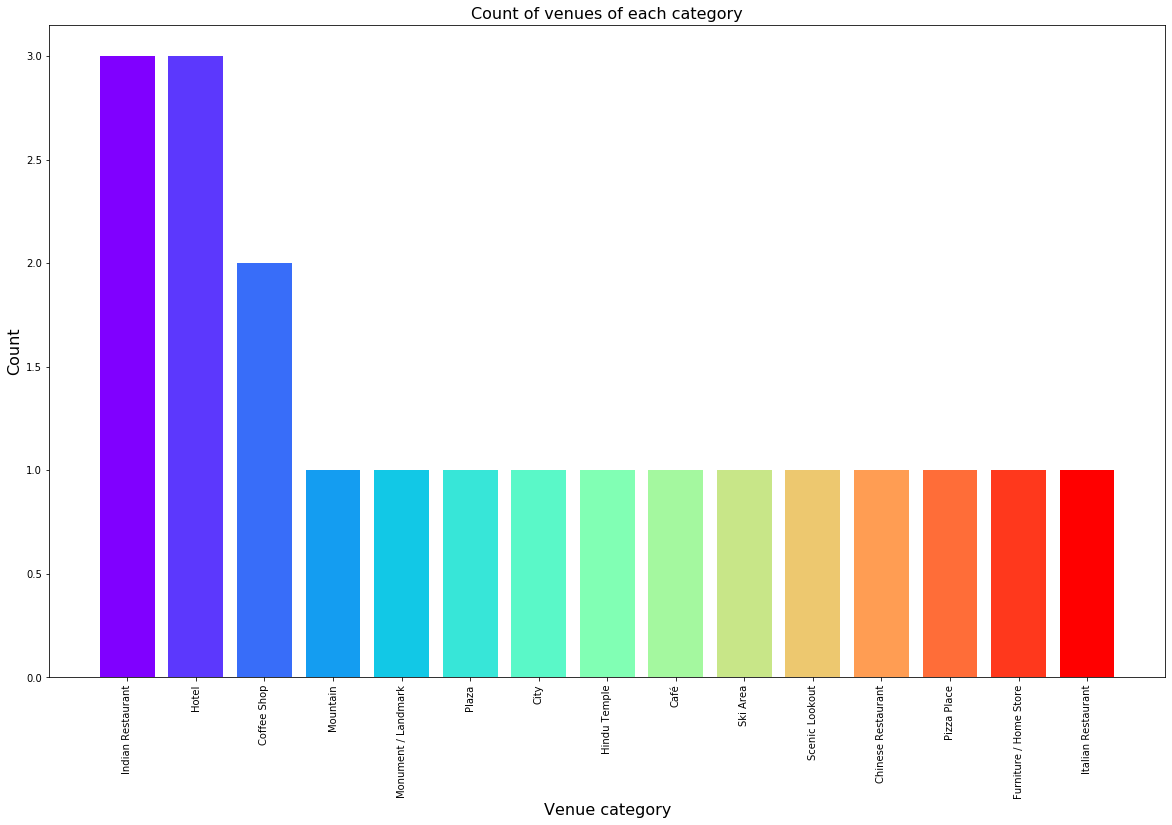

In [21]:
#histogram
venue_distribution = chosen_venues['categories'].value_counts()
colors = cm.rainbow(np.linspace(0, 1, len(venue_distribution.index)))
plt.figure(figsize = (20, 12))
plt.xticks(rotation = 90)
plt.xlabel("Venue category", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues of each category", fontsize = 16)
plt.bar(venue_distribution.index, venue_distribution.values, color = colors)


###  Rating

Rating of a venue is an important factor on which a visitor decides whether it is worth it to visit the place. To cater to this, we will first see what is the average rating for all the venues in the city. Next, we will plot the venues on the map and color code them.

We'll first identify the various rating values and plot them as a bar plot with their counts to see the most common rating.


Text(0.5, 1.0, 'Count of venues with given rating')

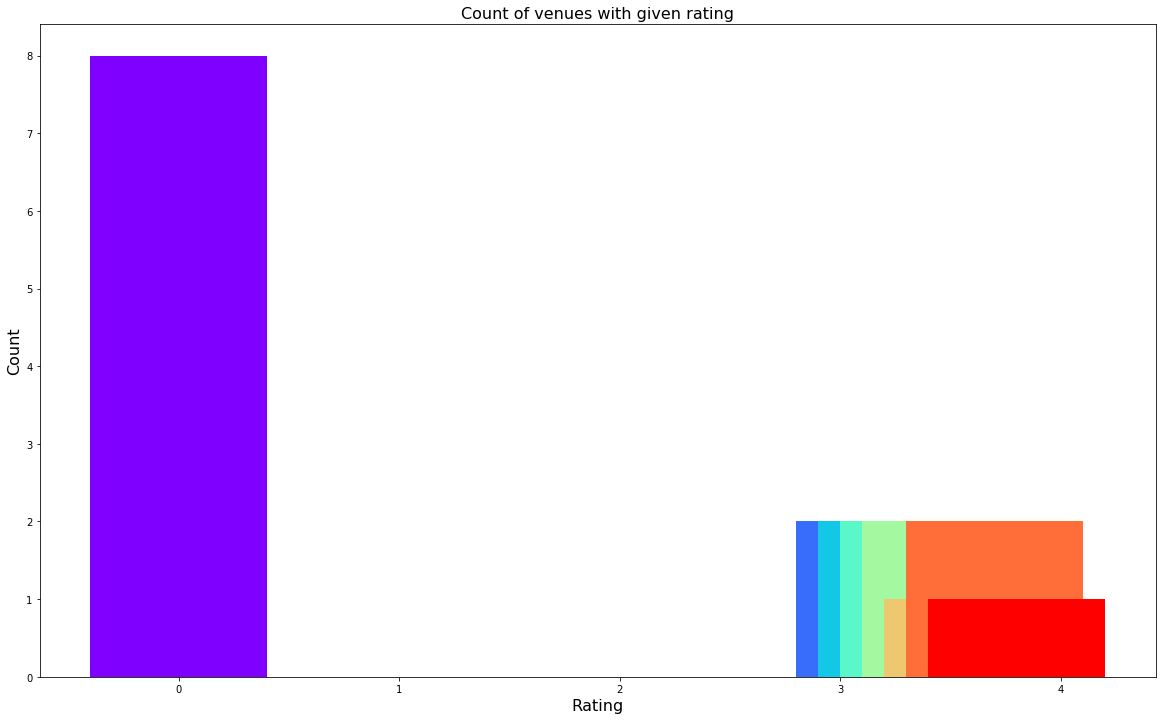

In [22]:
#rating
chosen_venues['rating'] = chosen_venues['rating'].astype(float)
rating = chosen_venues['rating'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.bar(rating.index, rating.values, color = cm.rainbow(np.linspace(0, 1, len(rating.index))))
plt.xlabel("Rating", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues with given rating", fontsize = 16)

In [23]:
bins = [1.0,2.0,3.0,5.0]
labels = ['Low','Mediocre','Good']
chosen_venues['rating_bin'] = pd.cut(chosen_venues['rating'].astype(float),bins = bins,labels= labels, include_lowest =True)

In [24]:
color_map = {'Low':'red','Mediocre':'yellow','Good':'green'}
shimla_map = folium.Map(location = [latitude,longitude],zoom_start = 12)
for name,address,latitude,longitude,rating_bin in zip(chosen_venues['venue'],chosen_venues['address'],chosen_venues['latitude'],chosen_venues['longitude'],chosen_venues['rating_bin']):
    label = '{}, {}'.format(name,address)
    label = folium.Popup(label, parse_html =True)
    folium.Marker([latitude,longitude],popup = label).add_to(shimla_map)
shimla_map.save("venues_ratings.html")
shimla_map

### Price

We will now take a look the venues based on the price values. We have two price features for our venues, one is average_price which defines the average cost for one person and the other is price_range which determines the price range as defined by Zomato.
We will first explore the average_price using a scatter plot between the price and the count of venues with that average price. We'll size the points based on the price to highlight their price.


Text(0.5, 1.0, 'Count of venues with given average price')

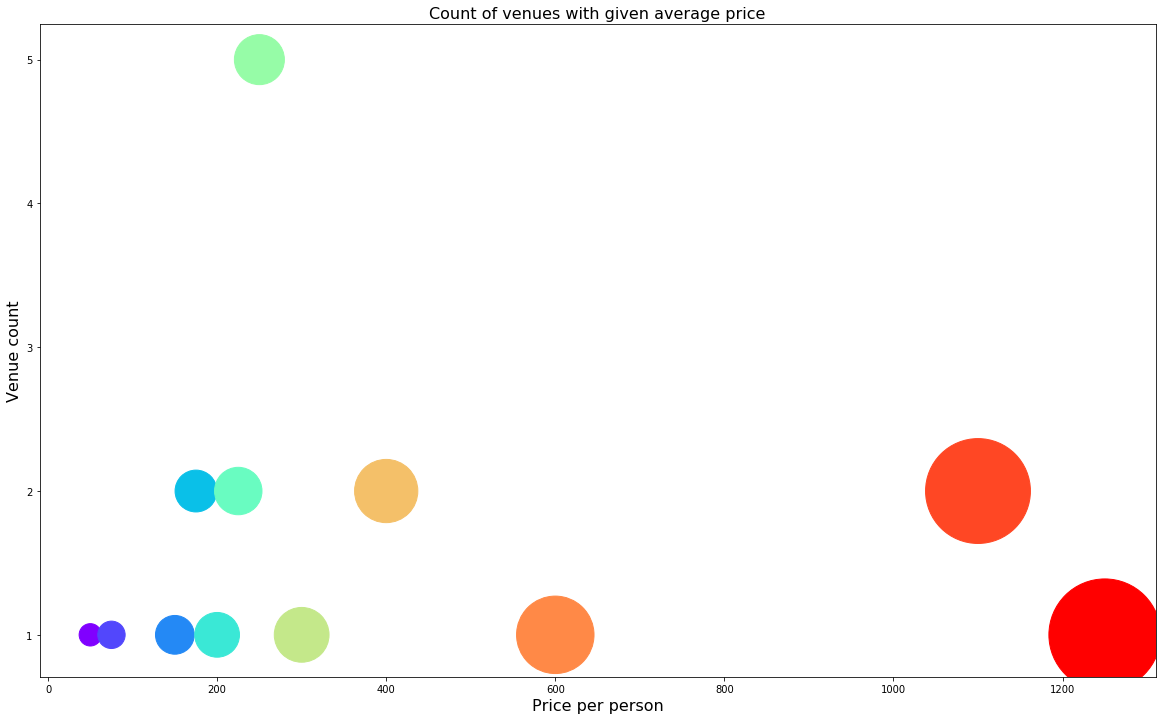

In [25]:
average_prices = chosen_venues['average_price'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.scatter(average_prices.index, 
            average_prices.values, 
            s = average_prices.index*10, 
            c = cm.rainbow(np.linspace(0, 1, len(average_prices.index))))
plt.xlabel("Price per person", fontsize = 16)
plt.ylabel("Venue count", fontsize = 16)
plt.title("Count of venues with given average price", fontsize = 16)

In [30]:
color_map = color_map = {'1.0': 'green', '2.0': 'darkgreen', '3.0': 'orange', '4.0': 'red'}
shimla_map  = folium.Map(loaction = [latitude,longitude],zoom_start = 12.30)
for name,address, latitude,longitude, price_range in zip(chosen_venues['venue'],chosen_venues['address'],chosen_venues['latitude'],chosen_venues['longitude'],chosen_venues['price_range'].astype(str)):
    label = '{}, {}'.format(name,address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker([latitude,longitude], popup= label).add_to(shimla_map)
shimla_map.save("Venues prices.html")
shimla_map

### Clustering

We will now cluster all these venues based on their price range, location and more to identify similar venues and the relationship amongst them. We'll cluster the venues into two separate groups.

In [36]:
#clustering

from sklearn.cluster import KMeans

NO_OF_CLUSTERS = 2

clustering = chosen_venues.drop(['venue', 'address', 'rating_bin', 'categories','long'],1)
kMeans = KMeans(n_clusters = NO_OF_CLUSTERS,random_state =2)
kMeans.fit(clustering)
chosen_venues.insert(0, 'cluster_labels', kMeans.labels_)
chosen_venues.head(5)

ValueError: cannot insert cluster_labels, already exists

In [35]:
shimla_map = folium.Map(location = [latitude,longitude], zoom_start = 13)
color_map = { 0: 'green', 1: 'red'}

# add venues to the map
markers_colors = []
for venue, address, cluster, latitude, longitude in zip(chosen_venues['venue'], 
                                                        chosen_venues['address'], 
                                                        chosen_venues['cluster_labels'], 
                                                        chosen_venues['latitude'], 
                                                        chosen_venues['longitude']):
    label = folium.Popup(str(venue) + ', ' + str(address), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = color_map[cluster],
        fill = True,
        fill_color = color_map[cluster],
        fill_opacity = 0.7).add_to(shimla_map)

# add cluster centers to the map
for index, cluster in enumerate(kMeans.cluster_centers_):
    latitude = cluster[0]
    longitude = cluster[1]
    label = folium.Popup("Cluster: " + str(index), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 10,
        popup = label,
        color = color_map[index],
        fill = True,
        fill_color = color_map[index],
        fill_opacity = 0.7).add_to(shimla_map)

shimla_map.save("venues clusters.html")
shimla_map



From the map, we see the two clusters:

    The first cluster is spread across the whole city and includes the majority venues.
    The second cluster is very sparsely spread and has very limited venues

In [38]:
result = chosen_venues[chosen_venues['cluster_labels'] == 0]
print("Cluster 0")
result.head(10).reset_index(drop = True)

Cluster 0


,cluster_labels,categories,long,venue,latitude,longitude,price_range,rating,address,rating_bin,average_price
0,0,Hotel,NaN,The Restaurant - The Oberoi Cecil,31.1032,77.1550,4.0,3.3,"The Oberoi Cecil, Nabha, State Museum Road, Lo...",Good,1100.0
1,0,Hotel,NaN,Seventh Heaven,31.1021,77.1773,4.0,3.2,"Hotel Combermere, Mall Road, Summer Hill, Shimla",Good,1250.0
2,0,Indian Restaurant,NaN,HPTDC Goofa Ashiana Bar and Restaurant,31.1047,77.1742,4.0,3.4,"Ridge, The Mall, Longwood",Good,1100.0


In [39]:
print("These venues for cluster 0 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 0 have mean price range of 4.00 and rating spread around 3.30


In [40]:
result = chosen_venues[chosen_venues['cluster_labels'] == 1]
print("Cluster 1")
result.head(10).reset_index(drop = True)

Cluster 1


,cluster_labels,categories,long,venue,latitude,longitude,price_range,rating,address,rating_bin,average_price
0,1,City,NaN,Dobby's,31.1052,77.1716,2.0,0.0,"Mall Road, Near Syndicate Bank, Summer Hill, S...",NaN,175.0
1,1,Plaza,NaN,Honey Hut,31.1044,77.1750,2.0,3.7,"Khadi Bhawan, Middle Bazaar, Mall Road, Summer...",Good,225.0
2,1,Furniture / Home Store,NaN,Fresh Juice Shop,31.1063,77.1782,1.0,0.0,"Lakkar Bazar, Longwood, Shimla",NaN,75.0
3,1,Monument / Landmark,NaN,HPMC Corner,31.1046,77.1749,1.0,0.0,"Lakkar Bazaar, Longwood, Shimla",NaN,50.0
4,1,Café,NaN,Wake & Bake,31.1047,77.1732,3.0,3.7,"34/2, The Mall Shimla, Teh. & Amp Distt, Shiml...",Good,400.0
5,1,Coffee Shop,NaN,Indian Coffee House,31.1054,77.1713,2.0,3.8,"1, The, Mall Rd, Lower Bazar, Shimla, Himachal...",Good,175.0
6,1,Indian Restaurant,NaN,Sher-e-Punjab,31.1033,77.1770,2.0,3.3,"Mall Road, Summer Hill, Shimla",Good,300.0
7,1,Hindu Temple,NaN,Cafe Under Tree,31.1008,77.1847,3.0,3.6,"1, Below Jakhoo Temple, Jakhu, Longwood",Good,600.0
8,1,Pizza Place,NaN,Domino's Pizza,31.1049,77.1728,2.0,3.5,"24, Mall Road, Summer Hill, Shimla",Good,200.0
9,1,Indian Restaurant,NaN,Baljees Sweet Shop,31.1048,77.1729,1.0,3.5,"Near Scandal Point, Summer Hill, Shimla",Good,150.0


In [41]:
print("These venues for cluster 1 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 1 have mean price range of 2.00 and rating spread around 1.86


### Conclusion


The purpose of this project was to explore the places that a person visiting Shimla could visit. The venues have been identified using Foursquare and Zomato API and have been plotted on the map. The map reveals that there are two major areas a person can visit: colored as green and red. Based on the visitor's venue rating and price requirements, he/she can choose amongst the two places.
